# 学习率衰减

对于基于一阶梯度进行优化的方法而言，开始的时候更新的幅度是比较大的，也就是说开始的学习率可以设置大一点，但是当训练集的 loss 下降到一定程度之后，，使用这个太大的学习率就会导致 loss 一直来回震荡，比如


![震荡](readme/22.01-02-震荡.jpg)

这个时候就需要对学习率进行衰减已达到 `loss` 的充分下降，而是用学习率衰减的办法能够解决这个矛盾，学习率衰减就是随着训练的进行不断的减小学习率。
在 `pytorch` 中学习率衰减非常方便，使用 `torch.optim.lr_scheduler`，更多的信息可以直接查看文档
但是我推荐大家使用下面这种方式来做学习率衰减，更加直观，下面我们直接举例子来说明


In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
from src.utils import resnet
from torchvision import transforms as tfs
from datetime import datetime

In [2]:
net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-4)

这里我们定义好了模型和优化器，可以通过 optimizer.param_groups 来得到所有的参数组和其对应的属性，参数组是什么意思呢？就是我们可以将模型的参数分成几个组，每个组定义一个学习率，这里比较复杂，一般来讲如果不做特别修改，就只有一个参数组
这个参数组是一个字典，里面有很多属性，比如学习率，权重衰减等等，我们可以访问以下

In [3]:
print('learning rate: {}'.format(optimizer.param_groups[0]['lr']))
print('weight decay: {}'.format(optimizer.param_groups[0]['weight_decay']))

learning rate: 0.01
weight decay: 0.0001


所以我们可以通过修改这个属性来改变我们训练过程中的学习率，非常简单

In [4]:
optimizer.param_groups[0]['lr'] = 1e-5

为了防止有多个参数组，我们可以使用一个循环

In [5]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-1

方法就是这样，非常简单，我们可以在任意的位置改变我们的学习率
下面我们具体来看看学习率衰减的好处

In [2]:
def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [3]:
# 使用数据增强
def train_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(120),
        tfs.RandomHorizontalFlip(),
        tfs.RandomCrop(96),
        tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

def test_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(96),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

train_set = CIFAR10('./data', train=True, transform=train_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=0)
valid_set = CIFAR10('./data', train=False, transform=test_tf)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=False, num_workers=0)

net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [4]:
train_losses = []
valid_losses = []

if torch.cuda.is_available():
    net = net.cuda()
prev_time = datetime.now()
for epoch in range(30):
    if epoch == 20:
        set_learning_rate(optimizer, 0.01) # 80 次修改学习率为 0.01
    train_loss = 0
    net = net.train()
    for im, label in train_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda())  # (bs, 3, h, w)
            label = Variable(label.cuda())  # (bs, h, w)
        else:
            im = Variable(im)
            label = Variable(label)
        # forward
        output = net(im)
        loss = criterion(output, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.data
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "Time %02d:%02d:%02d" % (h, m, s)
    valid_loss = 0
    valid_acc = 0
    net = net.eval()
    for im, label in valid_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda(), volatile=True)
            label = Variable(label.cuda(), volatile=True)
        else:
            im = Variable(im, volatile=True)
            label = Variable(label, volatile=True)
        output = net(im)
        loss = criterion(output, label)
        valid_loss += loss.data
    epoch_str = (
        "Epoch %d. Train Loss: %f, Valid Loss: %f, "
        % (epoch, train_loss / len(train_data), valid_loss / len(valid_data)))
    prev_time = cur_time

    train_losses.append(train_loss / len(train_data))
    valid_losses.append(valid_loss / len(valid_data))
    print(epoch_str + time_str)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 0. Train Loss: 2.081381, Valid Loss: 1.953318, Time 00:01:00
Epoch 1. Train Loss: 1.580365, Valid Loss: 1.778786, Time 00:01:01
Epoch 2. Train Loss: 1.322581, Valid Loss: 1.565874, Time 00:01:01
Epoch 3. Train Loss: 1.132525, Valid Loss: 1.856370, Time 00:01:01
Epoch 4. Train Loss: 0.987529, Valid Loss: 1.414945, Time 00:01:01
Epoch 5. Train Loss: 0.878258, Valid Loss: 1.011722, Time 00:01:01
Epoch 6. Train Loss: 0.792823, Valid Loss: 1.585819, Time 00:01:01
Epoch 7. Train Loss: 0.743024, Valid Loss: 1.269675, Time 00:01:01
Epoch 8. Train Loss: 0.689415, Valid Loss: 1.344355, Time 00:01:01
Epoch 9. Train Loss: 0.651682, Valid Loss: 1.087302, Time 00:01:01
Epoch 10. Train Loss: 0.613069, Valid Loss: 0.859802, Time 00:01:01
Epoch 11. Train Loss: 0.579034, Valid Loss: 0.804185, Time 00:01:01
Epoch 12. Train Loss: 0.553562, Valid Loss: 0.935954, Time 00:01:01
Epoch 13. Train Loss: 0.527706, Valid Loss: 0.958954, Time 00:01:01
Epoch 14. Train Loss: 0.505439, Valid Loss: 0.993481, Time

下面我们画出 loss 曲线

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

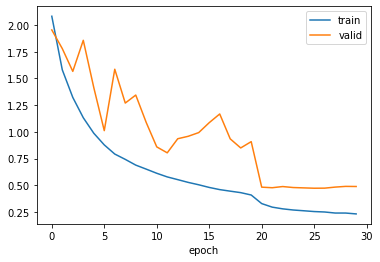

In [6]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epoch')
plt.legend(loc='best')

这里我们只训练了 30 次，在 20 次的时候进行了学习率衰减，可以看 loss 曲线在 20 次的时候不管是 train loss 还是 valid loss，都有了一个陡降。
当然这里我们只是作为举例，在实际应用中，做学习率衰减之前应该经过充分的训练，比如训练 80 次或者 100 次，然后再做学习率衰减得到更好的结果，有的时候甚至需要做多次学习率衰减